# Parte 1

## Reporte de Celdas Faltantes

In [53]:
import pandas as pd

titanic_md = pd.read_csv('titanic_MD.csv')

missing_report = titanic_md.isnull().sum()
missing_percentage = (titanic_md.isnull().sum() / len(titanic_md)) * 100
missing_data_report = pd.DataFrame({'Missing Values': missing_report, 'Percentage': missing_percentage})
print("Reporte de valores faltantes:\n", missing_data_report)

Reporte de valores faltantes:
              Missing Values  Percentage
PassengerId               0    0.000000
Survived                  0    0.000000
Pclass                    0    0.000000
Name                      0    0.000000
Sex                       0    0.000000
Age                      25   13.661202
SibSp                     3    1.639344
Parch                    12    6.557377
Ticket                    0    0.000000
Fare                      8    4.371585
Cabin                     0    0.000000
Embarked                 12    6.557377


## Análisis de distribución de las columnas con Nans

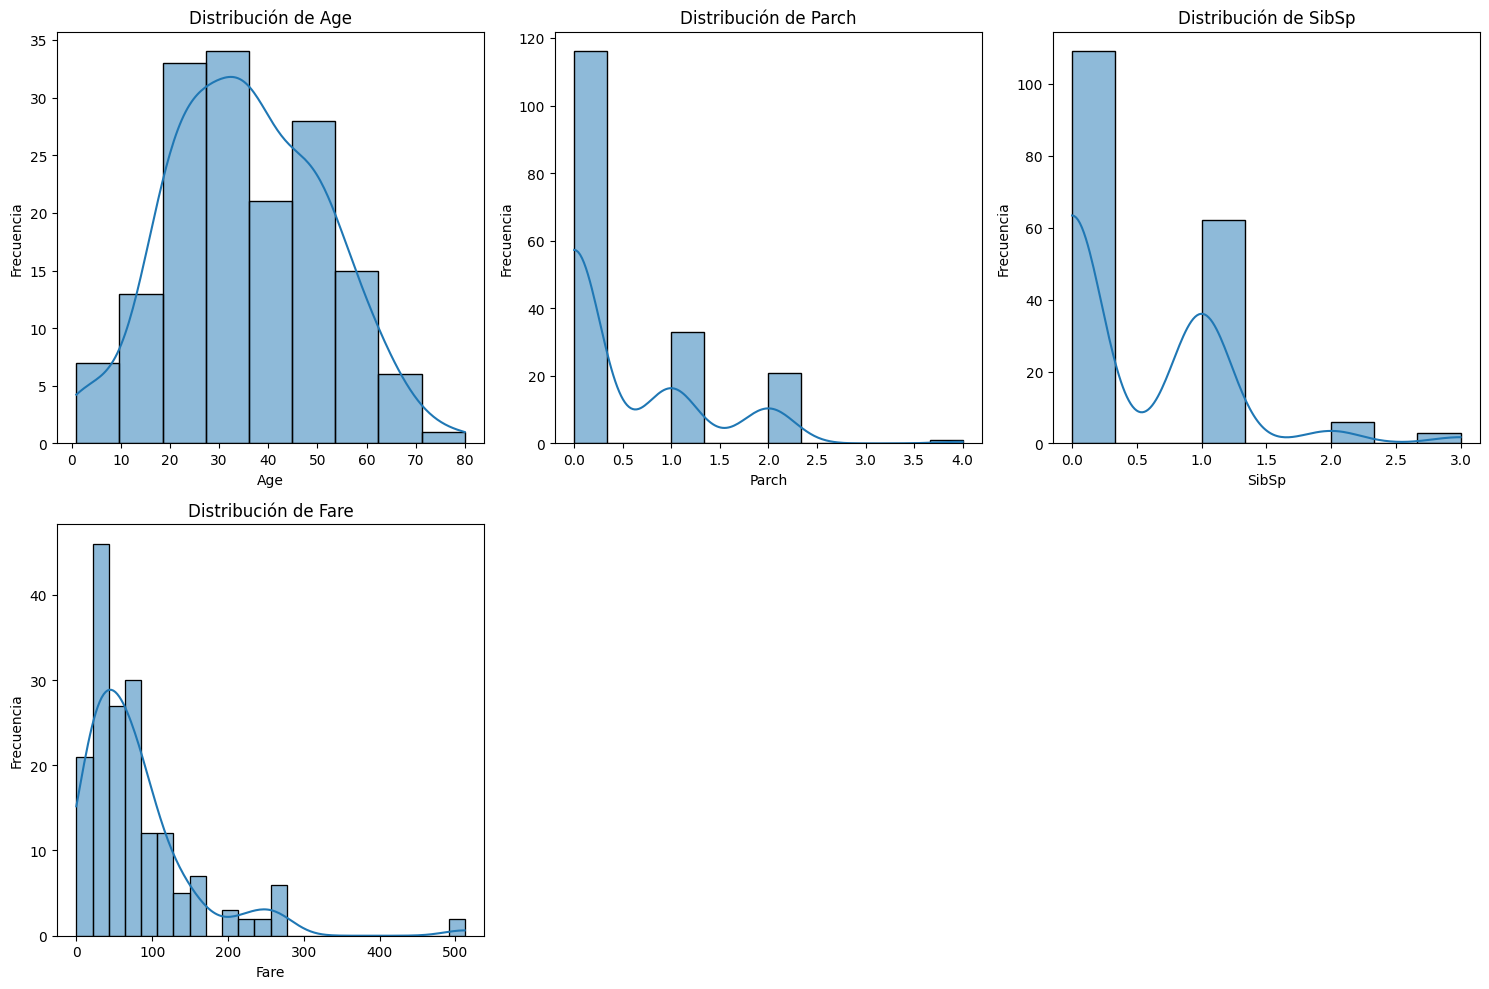

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

numeric_columns = ['Age', 'Parch', 'SibSp', 'Fare']

num_columns = len(numeric_columns)
cols = 3
rows = math.ceil(num_columns / cols)

plt.figure(figsize=(5 * cols, 5 * rows))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(titanic_md[column].dropna(), kde=True)
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

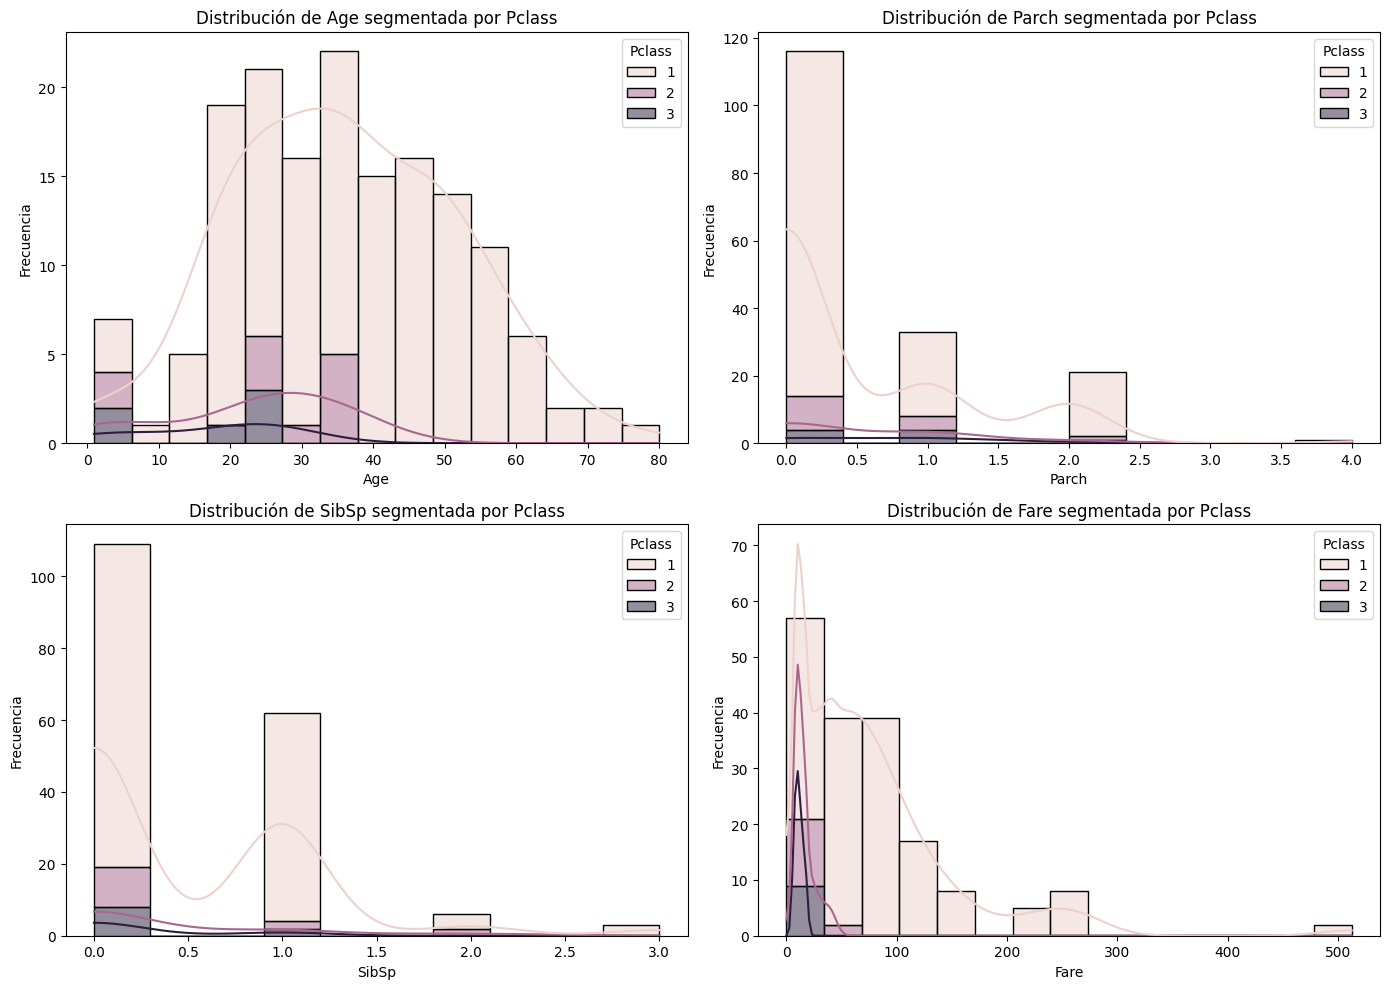

In [55]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.histplot(data=titanic_md, x='Age', hue='Pclass', kde=True, bins=15, multiple='stack')
plt.title('Distribución de Age segmentada por Pclass')
plt.xlabel('Age')
plt.ylabel('Frecuencia')

plt.subplot(2, 2, 2)
sns.histplot(data=titanic_md, x='Parch', hue='Pclass', kde=True, bins=10, multiple='stack')
plt.title('Distribución de Parch segmentada por Pclass')
plt.xlabel('Parch')
plt.ylabel('Frecuencia')

plt.subplot(2, 2, 3)
sns.histplot(data=titanic_md, x='SibSp', hue='Pclass', kde=True, bins=10, multiple='stack')
plt.title('Distribución de SibSp segmentada por Pclass')
plt.xlabel('SibSp')
plt.ylabel('Frecuencia')

plt.subplot(2, 2, 4)
sns.histplot(data=titanic_md, x='Fare', hue='Pclass', kde=True, bins=15, multiple='stack')
plt.title('Distribución de Fare segmentada por Pclass')
plt.xlabel('Fare')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

## Imputación de la variable categórica

In [56]:

print(titanic_md['Embarked'].value_counts())

embarked_mode_by_class = titanic_md.groupby('Pclass')['Embarked'].agg(lambda x: x.mode()[0])
print(embarked_mode_by_class)

titanic_md['Embarked'] = titanic_md.apply(
    lambda row: embarked_mode_by_class[row['Pclass']] if pd.isnull(row['Embarked']) else row['Embarked'],
    axis=1
)


Embarked
S    110
C     59
Q      2
Name: count, dtype: int64
Pclass
1    S
2    S
3    S
Name: Embarked, dtype: object


## Se elige los métodos de imputación para las variables con Nan

Age y Fare (imputación con media segmentada por Pclass):
La segmentación permite aprovechar patrones específicos entre las clases de pasajeros 
(primera, segunda y tercera) en la imputación de estos valores. Al observar la distribución, 
encontramos que la edad y la tarifa varían considerablemente entre clases, lo que sugiere 
que imputar la media general podría introducir un sesgo. Usar la media dentro de cada clase 
captura mejor las diferencias entre grupos y mejora la precisión de la imputación.


Parch y SibSp (imputación con la moda):
Estas columnas representan datos discretos, y los valores más comunes (moda) son 
cero o uno, lo que indica que la mayoría de los pasajeros no viajaban con padres, 
hijos o hermanos. Imputar con la moda mantiene la estructura de los datos y es adecuado 
para estos valores categóricos con alta frecuencia en categorías específicas. No se hace
por clase, ya que no se observa que haya una relación entre estas variables. 

Embarked (imputación con la moda):
Esta columna se hace por la moda, ya que se puede observar que la mayoría de perosnas
subieron en el puerto S, se intentó ver si las clases tenian algo que ver con respecto a 
esto, pero se puede ver que en las tres clases, la moda sigue siendo el valor S, por lo que
si se hacía por la moda general o la moda separada por clases, esto no iba a cambiar el
resultado

## Análisis de filas completas

In [58]:
titanic_complete = titanic_md.dropna()

reporte = {
    'Estadísticas descriptivas': titanic_complete.describe(),
}

for key, value in reporte.items():
    print(f"{key}:")
    print(value)
    print("\n")


Estadísticas descriptivas:
       PassengerId   Survived      Pclass         Age       SibSp       Parch  \
count   141.000000  141.00000  141.000000  141.000000  141.000000  141.000000   
mean    460.957447    0.64539    1.148936   35.364681    0.446809    0.496454   
std     235.002884    0.48010    0.446193   15.540947    0.602679    0.789431   
min       2.000000    0.00000    1.000000    0.920000    0.000000    0.000000   
25%     293.000000    0.00000    1.000000   24.000000    0.000000    0.000000   
50%     463.000000    1.00000    1.000000   35.000000    0.000000    0.000000   
75%     663.000000    1.00000    1.000000   48.000000    1.000000    1.000000   
max     888.000000    1.00000    3.000000   71.000000    3.000000    4.000000   

             Fare  
count  141.000000  
mean    81.690041  
std     78.977028  
min      0.000000  
25%     30.500000  
50%     61.979200  
75%     93.500000  
max    512.329200  




## Imputaciones por los 5 métodos

#### Creación de los df para realizar imputaciones

In [59]:

df_mean = titanic_md.copy()
df_median = titanic_md.copy()
df_mode = titanic_md.copy()
df_regression = titanic_md.copy()
df_outliers = titanic_md.copy()

### Imputación por Media

In [60]:
df_mean['Age'].fillna(df_mean['Age'].mean(), inplace=True)
df_mean['Fare'].fillna(df_mean['Fare'].mean(), inplace=True)
df_mean['Parch'].fillna(df_mean['Parch'].mean(), inplace=True)
df_mean['SibSp'].fillna(df_mean['SibSp'].mean(), inplace=True)

### Imputación por Mediana

In [61]:
df_median['Age'].fillna(df_median['Age'].median(), inplace=True)
df_median['Fare'].fillna(df_median['Fare'].median(), inplace=True)
df_median['Parch'].fillna(df_median['Parch'].median(), inplace=True)
df_median['SibSp'].fillna(df_median['SibSp'].median(), inplace=True)

### Imputación por Moda

In [62]:
df_mode['Age'].fillna(df_mode['Age'].mode()[0], inplace=True)
df_mode['Fare'].fillna(df_mode['Fare'].mode()[0], inplace=True)
df_mode['Parch'].fillna(df_mode['Parch'].mode()[0], inplace=True)
df_mode['SibSp'].fillna(df_mode['SibSp'].mode()[0], inplace=True)

### Imputación por Regresión

In [63]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

def impute_with_regression(df, target_column):

    complete_data = df.dropna(subset=[target_column])
    missing_data = df[df[target_column].isnull()]

    numeric_columns = df.select_dtypes(include=[np.number]).columns
    predictors = [col for col in numeric_columns if col != target_column]

    imputer = SimpleImputer(strategy='mean')
    X_complete = imputer.fit_transform(complete_data[predictors])
    y_complete = complete_data[target_column]

    reg_model = LinearRegression()
    reg_model.fit(X_complete, y_complete)

    X_missing = imputer.transform(missing_data[predictors])
    df.loc[df[target_column].isnull(), target_column] = reg_model.predict(X_missing)

impute_with_regression(df_regression, 'Age')
impute_with_regression(df_regression, 'Fare')
impute_with_regression(df_regression, 'Parch')
impute_with_regression(df_regression, 'SibSp')

### Imputación por Outliers

In [64]:
columns_with_missing = ['Age', 'Fare', 'Parch', 'SibSp']

def impute_outliers_based(df, column, lower_percentile=0.05, upper_percentile=0.95):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    
    df[column] = df[column].fillna(np.random.choice([lower_bound, upper_bound]))

for column in columns_with_missing:
    impute_outliers_based(df_outliers, column)

### Verificación de los 5 métodos

In [65]:
print("Imputación General - Media:")
print(df_mean.isnull().sum())

Imputación General - Media:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [66]:
print("\nImputación General - Mediana:")
print(df_median.isnull().sum())


Imputación General - Mediana:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [67]:
print("\nImputación General - Moda:")
print(df_mode.isnull().sum())


Imputación General - Moda:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [68]:
print("\nImputación por Modelo de Regresión:")
print(df_regression.isnull().sum())


Imputación por Modelo de Regresión:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [69]:
print("\nImputación con Percentile Approach (Outliers):")
print(df_outliers.isnull().sum())


Imputación con Percentile Approach (Outliers):
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


## Comparación de los 5 métodos con los datos reales

In [70]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

titanic_real = pd.read_csv("titanic.csv")

def compare_imputations(imputed_df, real_df, columns):
    comparison_results = []
    
    for column in columns:
        mask = real_df[column].notnull() & imputed_df[column].notnull()

        mae = mean_absolute_error(real_df.loc[mask, column], imputed_df.loc[mask, column])
        mse = mean_squared_error(real_df.loc[mask, column], imputed_df.loc[mask, column])
        
        comparison_results.append({
            "Column": column,
            "Mean Absolute Error (MAE)": mae,
            "Mean Squared Error (MSE)": mse
        })
    
    return pd.DataFrame(comparison_results)

columns_to_compare = ['Age', 'Fare', 'Parch', 'SibSp']

### Comparación por la media

In [71]:
comparison_report_mean = compare_imputations(df_mean, titanic_real, columns_to_compare)

print(comparison_report_mean)

  Column  Mean Absolute Error (MAE)  Mean Squared Error (MSE)
0    Age                   1.589740                 33.514203
1   Fare                   1.808524                155.951613
2  Parch                   0.043716                  0.039177
3  SibSp                   0.008409                  0.004336


### Comparación por la mediana

In [72]:
comparison_report_median = compare_imputations(df_median, titanic_real, columns_to_compare)

print(comparison_report_median)

  Column  Mean Absolute Error (MAE)  Mean Squared Error (MSE)
0    Age                   1.592896                 33.512295
1   Fare                   1.780145                164.975443
2  Parch                   0.043716                  0.065574
3  SibSp                   0.010929                  0.010929


### Comparación por la moda

In [73]:
comparison_report_mode = compare_imputations(df_mode, titanic_real, columns_to_compare)

print(comparison_report_mode)

  Column  Mean Absolute Error (MAE)  Mean Squared Error (MSE)
0    Age                   2.300546                 51.767760
1   Fare                   2.396357                247.021395
2  Parch                   0.043716                  0.065574
3  SibSp                   0.010929                  0.010929


### Comparación por regresión

In [74]:
comparison_report_regression = compare_imputations(df_regression, titanic_real, columns_to_compare)

print(comparison_report_regression)

  Column  Mean Absolute Error (MAE)  Mean Squared Error (MSE)
0    Age                   1.439433                 24.553618
1   Fare                   2.061359                158.110108
2  Parch                   0.044107                  0.042952
3  SibSp                   0.009326                  0.005501


### Comparación por outliers

In [75]:
comparison_report_outliers = compare_imputations(df_outliers, titanic_real, columns_to_compare)

print(comparison_report_outliers)

  Column  Mean Absolute Error (MAE)  Mean Squared Error (MSE)
0    Age                   3.374590                 99.692145
1   Fare                   2.747177                322.944631
2  Parch                   0.043716                  0.065574
3  SibSp                   0.006284                  0.006052


### Mejor resultado

Age: Regresión

Fare: Media

Parch: Media

SibSp: Media

Age: La edad de un pasajero podría estar correlacionada con otras variables, como la tarifa del boleto, la clase del pasajero o incluso el tamaño de su grupo familiar. Usar un modelo de regresión lineal permite aprovechar estas relaciones entre variables para hacer predicciones.

Fare: La tarifa del boleto varia ampliamente según la clase del pasajero, pero dentro de cada clase los valores tienden a concentrarse en torno a un promedio. Imputar con la media ayuda a mantener la coherencia del conjunto de datos sin introducir demasiada variación.

Parch: Aunque Parch representa un valor discreto, en promedio los pasajeros viajaban con pocos familiares. Usar la media para imputar funciona en este caso porque los valores originales son pequeños, y la media probablemente no introducirá valores extremos.

SibSp: Similar a Parch, representa el número de hermanos o cónyuges a bordo, que también tiende a ser pequeño. Usar la media para imputar valores faltantes mantiene la continuidad de los datos y evita que se sesgue demasiado hacia valores específicos. 

## Conclusión

Elegir el método de imputación depende de las características de la variable y su relación con otras columnas. Se debe de analizar bien que variable se esta tratando y cual es la mejor forma de poder llenar valores vaciós sin añadir mucho sesgo a la columna he intentado que lo que se ponga en esta, se relamente algo representativo de lo que se pueda llegar a ver en la realidad. Regresión lineal es útil para Age porque hay relaciones evidentes con otras variables.
Media es adecuada para Fare, Parch, y SibSp porque estas variables tienen distribuciones simples, rangos limitados y poca dependencia de otras columnas.

# Parte 2

## Realizar la imputación por el método seleccionado

### Prueba con los métodos seleccionados para comparar con las imputaciones anteriores

In [77]:
test_df = titanic_md.copy()

def impute_segmented_mean(df, column, segment_by):
    for group in df[segment_by].unique():
        mean_value = df[df[segment_by] == group][column].mean()
        df.loc[(df[column].isnull()) & (df[segment_by] == group), column] = mean_value

def impute_mean(df, column):
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)

impute_segmented_mean(test_df, 'Age', 'Pclass')
impute_segmented_mean(test_df, 'Fare', 'Pclass')

impute_mean(test_df, 'Parch')
impute_mean(test_df, 'SibSp')

In [78]:
comparison_report_own = compare_imputations(test_df, titanic_real, columns_to_compare)

print(comparison_report_own)

  Column  Mean Absolute Error (MAE)  Mean Squared Error (MSE)
0    Age                   1.625318                 29.335197
1   Fare                   1.234858                 96.725154
2  Parch                   0.043716                  0.039177
3  SibSp                   0.008409                  0.004336


In [79]:
## Se puede observar que al realizar la imputación por la media segmentada para age por el "pclass", 
## esta nos da un error mas alto a que si se hiciera solo por la media. 
## También se ve que para Parch y SibSp, se había escogido la moda, pero la media hace una mejor predicción. 

### Se hace la imputación en el df ya con las mejores opciones

In [80]:
def impute_segmented_mean(df, column, segment_by):
    for group in df[segment_by].unique():
        mean_value = df[df[segment_by] == group][column].mean()
        df.loc[(df[column].isnull()) & (df[segment_by] == group), column] = mean_value

def impute_mean(df, column):
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)

impute_segmented_mean(titanic_md, 'Fare', 'Pclass')

impute_mean(titanic_md, 'Parch')
impute_mean(titanic_md, 'SibSp')

impute_with_regression(titanic_md, 'Age')

In [82]:
comparison_report_own = compare_imputations(titanic_md, titanic_real, columns_to_compare)

print(comparison_report_own)

  Column  Mean Absolute Error (MAE)  Mean Squared Error (MSE)
0    Age                   1.435421                 24.359654
1   Fare                   1.234858                 96.725154
2  Parch                   0.043716                  0.039177
3  SibSp                   0.008409                  0.004336


## Normalización de datos

In [83]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

numeric_columns1 = titanic_md.select_dtypes(include=[float, int]).columns
numeric_columns2 = titanic_real.select_dtypes(include=[float, int]).columns

### Método Standarization

In [84]:
def standardize(df, columns):
    scaler = StandardScaler()
    df_standardized = df.copy()
    df_standardized[columns] = scaler.fit_transform(df[columns])
    return df_standardized

md_standar = standardize(titanic_md,numeric_columns1)
real_standar = standardize(titanic_real,numeric_columns2)

### Método MinMaxScaling

In [85]:
def minmax_scale(df, columns):
    scaler = MinMaxScaler()
    df_minmax = df.copy()
    df_minmax[columns] = scaler.fit_transform(df[columns])
    return df_minmax

md_minmax = minmax_scale(titanic_md,numeric_columns1)
real_minmax = minmax_scale(titanic_real,numeric_columns2)

### Método MaxAbsScaler

In [86]:
def maxabs_scale(df, columns):
    scaler = MaxAbsScaler()
    df_maxabs = df.copy()
    df_maxabs[columns] = scaler.fit_transform(df[columns])
    return df_maxabs

md_maxabs = maxabs_scale(titanic_md,numeric_columns1)
real_maxabs = maxabs_scale(titanic_real,numeric_columns2)

## Estadísticos Importantes

In [87]:
def calculate_statistics(df):
    stats = {
        'mean': df.mean(),
        'median': df.median(),
        'std': df.std(),
        'var': df.var(),
        'min': df.min(),
        'max': df.max(),
        'range': df.max() - df.min(),
        'skewness': df.skew(),
        'kurtosis': df.kurt()
    }
    return pd.DataFrame(stats)

### Comparación por método de standarization

In [94]:
estadisticos1 = calculate_statistics(md_standar.select_dtypes(include=[np.number]))
estadisticos2 = calculate_statistics(real_standar.select_dtypes(include=[np.number]))

comparison = estadisticos1 - estadisticos2

print("\nDiferencia entre Estadísticos Standarization:\n", comparison)


Diferencia entre Estadísticos Standarization:
                      mean    median           std           var       min  \
PassengerId  0.000000e+00  0.000000  0.000000e+00  0.000000e+00  0.000000   
Survived     0.000000e+00  0.000000  0.000000e+00  0.000000e+00  0.000000   
Pclass       0.000000e+00  0.000000  0.000000e+00  0.000000e+00  0.000000   
Age         -1.456030e-16 -0.024483  2.220446e-16  2.220446e-16 -0.066498   
SibSp        1.116290e-16  0.001455  2.220446e-16  2.220446e-16  0.001455   
Parch        1.067755e-16 -0.004459  0.000000e+00  0.000000e+00 -0.004459   
Fare        -3.397404e-17  0.011710  2.220446e-16  2.220446e-16 -0.008376   

                  max     range  skewness  kurtosis  
PassengerId  0.000000  0.000000  0.000000  0.000000  
Survived     0.000000  0.000000  0.000000  0.000000  
Pclass       0.000000  0.000000  0.000000  0.000000  
Age          0.157197  0.223695  0.156535  0.095272  
SibSp        0.026117  0.024662  0.034564  0.142279  
Parch      

### Comparación por método de MinMaxScaling

In [93]:
estadisticos3 = calculate_statistics(md_minmax.select_dtypes(include=[np.number]))
estadisticos4 = calculate_statistics(real_minmax.select_dtypes(include=[np.number]))

comparison = estadisticos3 - estadisticos4

print("\nDiferencia entre Estadísticos MinMaxScaling:\n", comparison)


Diferencia entre Estadísticos MinMaxScaling:
                  mean    median       std       var  min  max  range  \
PassengerId  0.000000  0.000000  0.000000  0.000000  0.0  0.0    0.0   
Survived     0.000000  0.000000  0.000000  0.000000  0.0  0.0    0.0   
Pclass       0.000000  0.000000  0.000000  0.000000  0.0  0.0    0.0   
Age         -0.006011 -0.010811 -0.008361 -0.003238  0.0  0.0    0.0   
SibSp       -0.001123  0.000000 -0.001128 -0.000483  0.0  0.0    0.0   
Parch       -0.003355  0.000000 -0.006611 -0.002451  0.0  0.0    0.0   
Fare        -0.000210  0.001911 -0.001401 -0.000416  0.0  0.0    0.0   

             skewness  kurtosis  
PassengerId  0.000000  0.000000  
Survived     0.000000  0.000000  
Pclass       0.000000  0.000000  
Age          0.156535  0.095272  
SibSp        0.034564  0.142279  
Parch        0.126514  0.663875  
Fare         0.054859  0.491204  


### Comparación por método de MaxAbsScaler

In [92]:
estadisticos5 = calculate_statistics(md_maxabs.select_dtypes(include=[np.number]))
estadisticos6 = calculate_statistics(real_maxabs.select_dtypes(include=[np.number]))

comparison = estadisticos5 - estadisticos6

print("\nDiferencia entre Estadísticos MaxAbsScaler:\n", comparison)


Diferencia entre Estadísticos MaxAbsScaler:
                  mean    median       std       var  min  max  range  \
PassengerId  0.000000  0.000000  0.000000  0.000000  0.0  0.0    0.0   
Survived     0.000000  0.000000  0.000000  0.000000  0.0  0.0    0.0   
Pclass       0.000000  0.000000  0.000000  0.000000  0.0  0.0    0.0   
Age         -0.005942 -0.010686 -0.008265 -0.003164  0.0  0.0    0.0   
SibSp       -0.001123  0.000000 -0.001128 -0.000483  0.0  0.0    0.0   
Parch       -0.003355  0.000000 -0.006611 -0.002451  0.0  0.0    0.0   
Fare        -0.000210  0.001911 -0.001401 -0.000416  0.0  0.0    0.0   

             skewness  kurtosis  
PassengerId  0.000000  0.000000  
Survived     0.000000  0.000000  
Pclass       0.000000  0.000000  
Age          0.156535  0.095272  
SibSp        0.034564  0.142279  
Parch        0.126514  0.663875  
Fare         0.054859  0.491204  


## Conclusión

MaxAbsScaler: En la media, mediana, desviación estándar y varianza presentan cambios insignificantes siendo casi 0, indicando que la escala relativa de los valores en cada columna se ha mantenido. La asimetría y curtosis no cambiaron, lo que nos dice que la distribución de los datos originales no se alteró.

MinMaxScaler: Los cambios fueron casi nuelo en media, mediana, desviación estándar y varianza. La asimetría y curtosis se mantuvieron, por lo que este método tampoco altera la forma de la distribución de los datos.

Standarization: La media de todas las columnas se aproximó a 0, debido a la naturaleza de este método.
La desviación estándar tomó valores cercanos a 1 por como funciona este método. La asimetría y curtosis permanecen sin cambios, lo que confirma que no hubo modificación de la forma de la distribución.

Realmente los cambios fueron mínios, por lo que los tres tipos de normalización funcionan bastante bien para este modelo. Se puede ver que también las impiutaciones que fueron realizadas resultaron bastante eficientes y no afectaron a la distribución del modelo.